# 💰Predict Future Sales Competiton💰: time series prediction with Linear Regression

Hi ! This is my second attempt and I still love Kaggle, so I will try to do the best to show you interesting findings that may help you win this competition ;)

Last time I went straight to a time series predictive model and it wasn't very successful (score of >3000). This time I will use a more simple approach: linear regression. And because I am feeling funky right now and that I want teach you how it works, we are going to do it from scratch :)

# 1. Competition Outline
In this competition we work with time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.

We are asked to predict total sales for every product and store in the next month.

But what is time series prediction?

> Time series forecasting is the use of a model to predict future values based on previously observed values.

# 2. Libraries

This time we won't import lots of libraries as we we do a linear regression from scratch

In [ ]:
# Imports

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra, we might not use it very much as we will do it from scratch
import plotly.express as px #just to design beautiful graphs

In [ ]:
import warnings

# settings
warnings.filterwarnings('ignore')

# 3. Data

This time we will take much more attention to the data, and focus lesss on the time perspective of it.

- `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015. It has 1034 unique values `item_id` that were sold at a given `shop_id` at `date_block_num` time.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015. 214k `item_id` sales to predict at `shop_id` for next `date_block_num` time.
- `sample_submission.csv` - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products. 22170
unique values, with the categories.
- item_categories.csv  - supplemental information about the items categories. 84
unique values.
- shops.csv- supplemental information about the shops. The name and sometimes the categories: TPK|ТЦ|ТК|ТРЦ|МТРЦ|ТЦ

In [ ]:
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
sub = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

# 4. Example: Linear Regression from scratch

A linear regression works when we have a linear relationship between variables. That's why we use correlation to measure the strength of the relationship. But knowing that such an relation exist isn't enough. We will want to  to understand the nature of the relationship. This is is where we'll ue simple linear regresion.

Let's take the example of an ecommerce website which have a certain number of people visiting it each day. Let's assume that I am convinced that the more often people visit the website causes them to have spend more.

This is where we can use a linear model to describe this relationship. In particular there are constants $\alpha$ an $\beta$ such that:

$$y_i = \beta x_i + \alpha + \epsilon_i$$

where $y_i$ is the spendings of customer $i$ and $x_i$ is the number of friends user $i$ has, and $\epsilon_i$ is the (hopefully small) error term representing the fact that there mu sbe other factors.

Assuming we have such an $\alpha$ and $\beta$ then we make prediction simply with:

```
def predict(alpha, beta, x_i):
    return beta * x_i + alpha
```

How do we chose $\alpha$ and $\beta$? Well, any choice gives us a predicted output for each input `x_i`. Since we know the actual output `y_i` we can compute the error for each pair. If add the square of this result on each pair we can chose $\alpha$ and $\beta$ that make the sum of the squarred errors as small as possible.

However we probably don't have only one feature about how often that visiting guy of our website visited it for our model. Probably I know what he already has bought, how much it was ... that leads us to **multiple regression**:

$$y_i = \alpha +\beta_1x_{i1} + ... + \beta_kx_{ik} + \epsilon_i$$

In multiple regression the vector of parameters is usually called $\beta$. We'll want this to include the canstant term as well, which we can achieve by adding a column of ones to our data:

```
beta = [alpha, beta_1, ..., beta_k]
```

and:

```
x_i = [1, x_i1, ..., x_ik]
```

Then our model is just:

In [ ]:
def predict(x_i, beta):
    """assumes that the first element of each x_i is 1"""
    return np.dot(x_i, beta)

In this particular case, our independant variable `x` will be a list of vectors, each of which looks like this

```
[1,   # constant 
 49,  # how often he visited before buying
 4,   # how many products he looked at 
 250] # mean price of the products
```

There are other assumptions that are required for this model to make sense: 

1. the first is that the columns of x are _linearly independant_ - that there is no way to write one as weighted sum of the others. If this assumption fails, it's impossible to estimate `beta`. To see this in an extreme case, imagine we had an extra field `double_price`. Then any augmentation of `price` coefficient and reduction in `double_price` coefficient would leave the model unchanged. 

2. The second important assumption is that the columns of `x` are all uncorrelated with the errors $\epsilon$. Otherwise our $\beta$ estimates would always be wrong.

## Fitting the model

As in the simple linear model, we'll chose beta to minimize the sum of squared errors. Finding an exact solution is not simple to do by hand, which means we'll need to use gradient descent. We'll start by creating an error function to minimize. For stochastic gradient descent, we'll just want the squarred error corresponding to a single prediction.

In [ ]:
def error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def squared_error(x_i, y_i, beta):
    return error(x_i, y_i, beta) ** 2

If you know calculus you can compute:

In [ ]:
def squared_error_gradient(x_i, y_i, beta):
    """The gradient (with respect to beta)
    correspond to the ith squared error term"""
    return [-2 * x_ij * error(x_i, y_i, beta)
           for x_ij in x_i]

From here, we're ready to find the optimal beta using stochastic gradient descent:

In [ ]:
def estimate_beta(x, y):
    beta_initial = [random.random() for x in x[0]]
    return minimize_stochastic(squared_error,
                              squared_error_gradient,
                              x, y,
                              beta_initial,
                              0.01)

We still need to create `minimize_stochastic`. The predictive errors are additive, which means that the predictive error on the whole data set is simply the sum of the predictive errors for each data point. So we can instead apply a technique called stochastic gradient descent, which computes the gradient (and takes a step) for only one point at a time. It cycles over our data to iterate through our data in random order.

In [ ]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
#     print("[x for x in enumerate(data)]", [x for x in enumerate(data)])
    indexes = [i for i, _ in enumerate(data)] # create a list of indexes
    random.shuffle(indexes)                   # suffle them
    for i in indexes:
        yield data[i]

And we'll want to take a gradient step from each data point. This apporach leaves the possibility that we might curcle around near a minimum for ever, so whenever we stop getting improvements we'll decrease the step size and eventually quit:

In [ ]:
thetas_value = []

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=2/97592458):
    print("My minimize stochstic function parameters: ")
    print(target_fn)
    print(gradient_fn)
#     print("x: ",x)
#     print("y: ", y)
    data = zip(x,y)
    print("theta_0: ", theta_0)
    print([(x_i, y_i) for x_i, y_i in zip(x, y)])
    print("data: ", data)
    print("--------------------")
    theta = theta_0                           # the initial guess
    alpha = alpha_0                           # initial step size
    min_theta, min_value = None, float("inf") # the minimum so far
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement <100:
        data = zip(x,y)
        value = sum([target_fn(x_i, y_i, theta) for x_i, y_i in data])
        thetas_value.append({"beta0": theta[0], "beta1": theta[1], "beta2": theta[2], "cost": value[0]})
        if value < min_value:
            # if we've found a new minimum, remeber it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step_size
            iterations_with_no_improvement += 1
            alpha *= 0.9
        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(list(zip(x,y))):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = np.subtract(theta, [alpha * x[0] for x in gradient_i])
            
    return min_theta


In [ ]:
# ! pip install numdifftools

In [ ]:
import random
random.seed(0)
print([random.random() for x in [1, 49, 4, 2500]])


In [ ]:
Stock_Market = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
                'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]        
                }

df = pd.DataFrame(Stock_Market,columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price']) 

df['Ones'] = 1
# print(df)
x = df[['Ones', 'Interest_Rate', 'Unemployment_Rate']].values
y = df[['Stock_Index_Price']].values

beta = estimate_beta(x, y)

In [ ]:
beta

This means our model looks like:

$$Stock\_Index\_Price = 80.2 + 550.52 \ interest\_rates -26.18 \ Unemployment\_rate $$

# 5. Explenatory data analysis

Now, let's take a look at the data we were provided.

`sales_train` is the record of all sales of an `item_id` by `shop_id` and `date`.

In [ ]:
sales_train.head()

We have to transform the date to one readable by our softwares.

In [ ]:
sales_train['date'] = pd.to_datetime(sales_train['date'])

In [ ]:
sales_train.describe()

Let's have a look at the items name now. Nothing much of interest here.

In [ ]:
items.head()

`item_categories` is more interesting as we will be able to create subcategories from there.

In [ ]:
item_categories.head()

Indeed, one can see that we have first the category before - and then a subcategory.

In [ ]:
# extracting sub categories from item_category_name

## splitting the category by '-'
item_categories['categories'] = item_categories['item_category_name'].str.split('-')

## Extracting the first element from split
item_categories['type'] = item_categories['categories'].apply(lambda x: x[0].strip())

## Extracting the second element if there is a second element, else return first element
item_categories['sub_type'] = item_categories['categories'].apply(lambda x: x[1].strip() if len(x) >1 else x[0].strip())



Some categories have even more details on the right:

In [ ]:
item_categories['categories'].apply(lambda x: x[1].strip() if len(x) >1 else x[0].strip())

In [ ]:
# Dropping unnecessary columns

item_categories.drop(['item_category_name', 'categories'], inplace=True, axis=1)

In [ ]:
# plotting
fig = px.bar(item_categories.groupby('type')['sub_type'].count(), title = "Number of sub categories in Each Category")
fig.show()

# Shops

In [ ]:
shops.head()

Here you really need to look at the whole dataframe and you would notice that some rows seem duplicated.

In [ ]:
print(shops.iloc[[0,57]])
print("--")
print(shops.iloc[[1,58]])
print("--")
print(shops.iloc[[10,11]])

Probably the best thing to do would be to detect that with some NLP

In [ ]:
shops.loc[shops['shop_id']==0, 'shop_id'] = 57
shops.loc[shops['shop_id']==1, 'shop_id'] = 58
shops.loc[shops['shop_id']==10, 'shop_id'] = 11

In [ ]:
shops = shops.drop_duplicates(subset='shop_id')

Should you translate these shop names you would realise something interesting.

In [ ]:
! pip install google_trans_new

In [ ]:
from google_trans_new import google_translator  
translator = google_translator()    
shops['shop_name_en'] = shops['shop_name'].apply(translator.translate,lang_tgt='en')

In [ ]:
shops['shop_name_en'].head()

All this cities start with the name of the city the shop is localised

Let's remove the !

In [ ]:
shops.shop_name_en = shops.shop_name_en.replace(r'^! ', '', regex=True)

In [ ]:
shops['city'] = shops['shop_name_en'].str.split(' ').apply(lambda x: x[0])

In [ ]:
shops['city'].head()

We can now plot the number of store in each city

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="kaggle")

In [ ]:
shops.head()

Let's get the GPS location:

In [ ]:
import requests
import json

yandex_apikey = '1e6bf15c-981a-47ec-a263-7bb089b9dec6'


def get_gps_location(address):
    try:
        response = requests.get(
            "https://geocode-maps.yandex.ru/1.x/",
            params=dict(format="json", apikey=yandex_apikey, geocode=address),
        )
        data = response.json()["response"]
        coordinates = data["GeoObjectCollection"]['featureMember'][0]['GeoObject']["Point"]["pos"].split(" ")
        coordinates = [float(x) for x in coordinates]
        return coordinates
    except:
        return None, None
    

In [ ]:
shops[['lon','lat']] = shops.apply(lambda row: get_gps_location(row.shop_name),
                                    axis="columns", result_type="expand")

In [ ]:
shops.head()

The task is to predict sales for each item in a given store for the next month. So I will represent monthly sales per item per store.

In [ ]:
# Merging the dataframes

## merging sales_train with items
df = pd.merge(sales_train, items, how='left', on='item_id')

In [ ]:
## merging df with item_categories
df = pd.merge(df, item_categories, how='left', on='item_category_id')

In [ ]:
#merging df and shops
df = pd.merge(df, shops, how='left', on='shop_id')

Now we need to group by month, shop_id, item_id to get total sales

In [ ]:
data = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price':'mean', 'item_cnt_day':'sum'}).reset_index()
data.head()

And now we merge again to get all the data (categories, localisation ...) we left.

In [ ]:
# merging sales_train with item
data = pd.merge(data, items, how='left', on='item_id')

##merging df and item_categories
data = pd.merge(data, item_categories, how = 'left', on='item_category_id')

## merging df and shops
data = pd.merge(data,shops, how='left', on='shop_id')

In [ ]:
data.tail()

### Data Processing

Let's make month like date_block_num

In [ ]:
# month
data['month'] = data['date_block_num'].apply(lambda month: (month+1)%12)

Then we **dummify** to have categorical encoding of the different shops, types and subtybes of items?

In [ ]:
# dummies
data = pd.concat([data, pd.get_dummies(data['shop_id'], 
                                       drop_first=True, 
                                       prefix='shop_')], axis=1)

data = pd.concat([data, pd.get_dummies(data['type'],
                                      drop_first=True,
                                      prefix='type')], axis=1)

data = pd.concat([data, pd.get_dummies(data['sub_type'],
                                      drop_first=True,
                                      prefix='sub_type',
                                      )], axis=1)


Now we create a feature for the type of store.

In [ ]:
store_types = ['МТРЦ', 'TPK','ТЦ','ТК','ТРЦ']

def get_store_type(x):
    if type(x) != float:
        words = x.split(' ')
        return next((store_types.index(s) for x in words for s in store_types if x in s),None)
    else: return 5 # online

data['shop__type'] = data['shop_name'].apply(get_store_type)

Now let's gather the column names that will be used as features.

In [ ]:
# Getting the names of the feature columns

# Collecting shop feature names
shop_columns = [col for col in data.columns if 'shop__' in col]

## Collecting type feature names
type_columns = [col for col in data.columns if 'type_' in col]

## Collecting sub_type feature names
sub_type_columns = [col for col in data.columns if 'sub_type_' in col]

## collecting geo features
geo_columns = ['lat', 'lon']

In [ ]:
# setting the features and target variable
features = ['month', 'shop_id', 'item_id', 'item_price'] + geo_columns + shop_columns + type_columns + sub_type_columns 
# features = ['month', 'shop_id', 'item_id', 'item_price'] + geo_columns + type_columns + sub_type_columns 
target = ['item_cnt_day']

In [ ]:
data[features].head()

## Submission

Now that we have trained our linear regression model (it now has the right weight), we are going to use them on the test/submission set, provided separately.

We first need to create the futures that will be shared with the data we got for training. That is t say we need to derive what are the types and subtypes of our every items, the locations based on the shop_id...

In [ ]:
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

In [ ]:
# adding data_block_num with our target month
test['date_block_num'] = 34
test['month'] = 11

In [ ]:
item_price = data[['item_id', 'item_price']].groupby('item_id')['item_price'].mean().reset_index()

In [ ]:
item_price.head()

In [ ]:
# merging the test data with dataframes

##merging sales_train with item
test = pd.merge(test, item_price, how='left', on='item_id')

## merging items with test
test = pd.merge(test, items, how='left', on='item_id')

##merging df and item_categories
test = pd.merge(test, item_categories, how='left', on='item_category_id')

## merging test and shops
test = pd.merge(test, shops, how='left', on='shop_id')

In [ ]:
store_types = ['МТРЦ', 'TPK','ТЦ','ТК','ТРЦ']

def get_store_type(x):
    if type(x) != float:
        words = x.split(' ')
        return next((store_types.index(s) for x in words for s in store_types if x in s),None)
    else: return 5 # online

test['shop__type'] = test['shop_name'].apply(get_store_type)

In [ ]:
test.head()

Perfect, now our test dataframe looks ready to be dummified.

In [ ]:
# Dummifying the categorical columns

# Creating dummies on shop_ids
test = pd.concat([test, pd.get_dummies(test['shop_id'], drop_first=True, prefix='shop_')], axis=1)

# Creating dummies on types
test = pd.concat([test, pd.get_dummies(test['type'], drop_first=True, prefix='type_')], axis = 1)

# Creating dummies on sub_types
test = pd.concat([test, pd.get_dummies(test['sub_type'], drop_first=True, prefix='sub_type')], axis =1)

Yet, some features in training data aren't shared by test data. Let's take only the features taht are in both.

In [ ]:
# getting the names of the features columns

# Collectin shop names features
test_shop_columns = [col for col in test.columns if 'shop__' in col]

# Collecting item types features
test_type_columns = [col for col in test.columns if 'item_' in col]

# Collecting sub_type feature names 
test_sub_type_columns = [col for col in test.columns if 'sub_type_' in col]

# Geo?
test_geo_columns = ['lat', 'lon']

In [ ]:
# setting the feature and target variable

test_features = ['month', 'item_id', 'shop_id', 'item_price'] + test_shop_columns + test_type_columns + test_sub_type_columns + test_geo_columns



In [ ]:
print(f"Number of predictors in train data: {len(features)}")
print(f"number of predictors in test data: {len(test_features)}")
common_features = list(set(features) & set(test_features))
print(f"Common features: {len(common_features)}")

### baseline model using linear regression

We split data into training set and test set in everyday machine learning analyses, and oftentimes we use scikit-learn’s random splitting function.

```
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
```

However because we are dealing with time series here, we can't since observations in our time series datasets are not independent [as Alexander Guschin pointed out in data his data splitting strategies lecture in week 2](https://www.coursera.org/learn/competitive-data-science/lecture/0jtAV/data-splitting-strategies).

As a result to deal with that proble we can use 

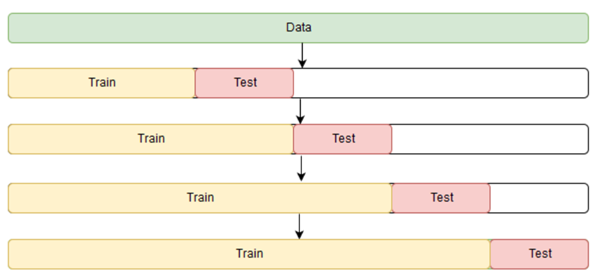

In [ ]:
# Preparing data for modeling

## Setting feature and target variables
X_train = data[common_features].fillna(value=0)
y_train = data[target].fillna(value=0)

Unfortunately I wasn't able to use my own linear regressor as it seems we have too much data, more than one million rows. 

In [ ]:
X_train.shape

So I got an error message: `Your notebook tried to allocate more memory than is available. It has restarted.`
As a result I will load a normal linear regression model from sklearn.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

lr= LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    print(tr_index, val_index)
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    ## fitting on training data
    lr.fit(X_tr, y_tr)
    lr.score(X_val, y_val)
    score.append([i, lr.score(X_val, y_val)])
    i += 1

# Linear Regression using common features

Okay, now we are all set to apply the linear regression model we did to the test set.

In [ ]:
test = test.fillna(0)

In [ ]:
test['preds'] = lr.predict(test[common_features])

We are adapting the dataframe to the required submission dataframe.

In [ ]:
preds = test[['ID', 'preds']]

preds.columns = ['ID', 'item_cnt_month']
preds.head()

In [ ]:
# saving the submission dataframe
preds.to_csv('my_submission.csv', index=False)

# Conclusion

All right, submission scored 2.81936 on the leader board. That's an improvement but that's not better than the submission setting everything to 0.5. In order to improve could try to do a linear regression model with a kfold validation technique for each of the item_id, shop_id.